<a href="https://colab.research.google.com/github/Akhil-py/Image-Classifier/blob/main/Copy_of_ACM_AI_WI24_Workshop_1_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ACM AI Winter 2024 Workshop #1: SVM, Image Classification

In [5]:
import os
import tarfile
import numpy as np
from torchvision.datasets.utils import download_url
import matplotlib.pyplot as plt
import skimage as ski
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.utils import shuffle

%matplotlib inline

## Download CIFAR-100

In [7]:
# Dowload the dataset
dataset_url = "https://s3.amazonaws.com/fast-ai-imageclas/cifar100.tgz"
download_url(dataset_url, '.')

100%|██████████| 169168619/169168619 [00:04<00:00, 35802666.26it/s]


In [8]:
# Extract from archive
with tarfile.open('./cifar100.tgz', 'r:gz') as tar:
    tar.extractall(path='./data')
data_dir = './data/cifar100'

See that in the data/cifar100 folder. We have our **train** and **test** sets. In each sets, we have 20 major categories.

In [9]:
# Print Superclass
superclasses = os.listdir(os.path.join(data_dir, 'train'))
print("Superclasses:")
for c in superclasses:
  print("-", c)

Superclasses:
- large_man-made_outdoor_things
- aquatic_mammals
- insects
- trees
- non-insect_invertebrates
- large_omnivores_and_herbivores
- fruit_and_vegetables
- vehicles_1
- large_carnivores
- medium_mammals
- household_furniture
- food_containers
- large_natural_outdoor_scenes
- reptiles
- people
- household_electrical_devices
- flowers
- fish
- small_mammals
- vehicles_2


## Choose a superclass you like

In [10]:
# Pick a superclass as your dataset
cat = "medium_mammals"

In [11]:
# Print classes from your selected superclass
classes = os.listdir(os.path.join(data_dir, 'train', cat))
print("Classes of", cat)
for c in classes:
  print("-",c)

Classes of medium_mammals
- skunk
- possum
- porcupine
- raccoon
- fox


## Load Data

In [12]:
# Load raw image data into each class in class_data

train_dir = os.path.join(data_dir, 'train', cat)
test_dir = os.path.join(data_dir, 'test', cat)

class_data = {}

for c in classes:
  class_train_dir = os.path.join(train_dir, c)
  class_test_dir = os.path.join(test_dir, c)

  train_files = [os.path.join(class_train_dir, f) for f in os.listdir(class_train_dir)]
  test_files = [os.path.join(class_test_dir, f) for f in os.listdir(class_test_dir)]

  class_data[c] = {'train' : train_files, 'test' : test_files}

Image shape: (32, 32, 3)
Train data size per class: 500
Test data size per class: 100


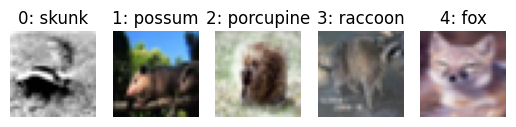

In [13]:
# Plot an example image of each class

fig, ax = plt.subplots(1,len(classes))
for i, c in enumerate(classes):
  im = ski.io.imread(class_data[c]['train'][0])
  ax[i].imshow(im)
  ax[i].set_title(f'{i}: {c}')
  ax[i].axis('off')
fig.show()

print('Image shape:', im.shape)
print('Train data size per class:', len(class_data[c]['train']))
print('Test data size per class:', len(class_data[c]['test']))

In [14]:
# Convert our dictionary into a nparray for training. Also, shuffle the data.

X_train = [] # train images
y_train = [] # train labels
for i, c in enumerate(classes):
  X_train.extend([ski.io.imread(filepath) for filepath in class_data[c]['train']])
  y_train.extend([i for filepath in class_data[c]['train']]) # i = class index
X_train = np.array(X_train)
y_train = np.array(y_train)
X_train, y_train = shuffle(X_train, y_train, random_state=0)


_X_test = [] # test images
_y_test = [] # test labels
for i, c in enumerate(classes):
  _X_test.extend([ski.io.imread(filepath) for filepath in class_data[c]['test']])
  _y_test.extend([i for filepath in class_data[c]['test']])
_X_test = np.array(_X_test)
_y_test = np.array(_y_test)
_X_test, _y_test = shuffle(_X_test, _y_test, random_state=0)

In [15]:
print('Shapes of Original Sets:')
print('Training set:', X_train.shape)
print('Testing set:', _X_test.shape)

Shapes of Original Sets:
Training set: (2500, 32, 32, 3)
Testing set: (500, 32, 32, 3)


## Training-Validation-Testing Sets Split

Right now, we have the train and test set. We need to reformat it for our SVM and include a validation set.

Let's split the original test set to half test and half validation.

In [18]:
# Please implement an even validation-test split
# Hint: use train_test_split()
X_val, X_test, y_val, y_test = train_test_split(X_train, y_train)

In [19]:
print('Shapes of Split Sets:')
print('Training set:', X_train.shape)
print('Validation set:', X_val.shape)
print('Testing set:', X_test.shape)

Shapes of Split Sets:
Training set: (2500, 32, 32, 3)
Validation set: (1875, 32, 32, 3)
Testing set: (625, 32, 32, 3)


Check if your images still match to your labels.

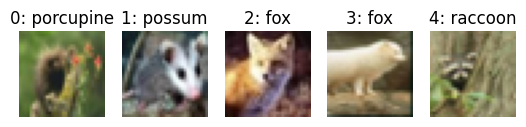

In [20]:
fig, ax = plt.subplots(1,5)
for i in range(5):
  ax[i].imshow(X_val[i])
  ax[i].set_title(f'{i}: {classes[y_val[i]]}')
  ax[i].axis('off')
fig.show()

## Flatten and normalize data for SVM

In [21]:
# Flatten and normalize data as input for SVM
# (num_img, h, w, channels) --> (num_img, num_features)

_, image_height, image_width, image_channels = X_train.shape

X_train_flat = np.array(X_train).reshape(-1, image_height * image_width * image_channels).astype('float') / 255
X_val_flat = np.array(X_val).reshape(-1, image_height * image_width * image_channels).astype('float') / 255
X_test_flat = np.array(X_test).reshape(-1, image_height * image_width * image_channels).astype('float') / 255

In [22]:
print('Shapes of Flattened Sets:')
print('Training set:', X_train_flat.shape)
print('Validation set:', X_val_flat.shape)
print('Testing set:', X_test_flat.shape)

Shapes of Flattened Sets:
Training set: (2500, 3072)
Validation set: (1875, 3072)
Testing set: (625, 3072)


## Implement Your Support Vector Machines (SVM)

In [23]:
# Initiate SVM model
# Hint: use SVC()
model = SVC()

In [24]:
# Train
# Hint: use model.fit()
model.fit(X_train_flat, y_train)

SVC()

In [26]:
# Make predictions for validation or testing set
# Hint: use model.predict()
y_pred = model.predict(X_test_flat)

In [43]:
# Generate classification report
# Hint: use classification_report()
print(classification_report(X_test_flat, y_pred)) ##

ValueError: Classification metrics can't handle a mix of continuous-multioutput and multiclass targets

Let's plot some results!

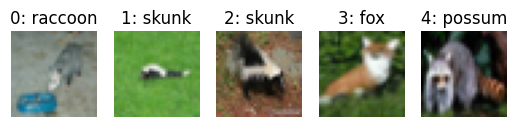

In [41]:
num_samples = 5
random_indices = np.random.choice(X_test.shape[0], num_samples, replace=False)
fig, ax = plt.subplots(1,num_samples)
for i in range(num_samples):
  ax[i].imshow(X_test[random_indices[i]])
  ax[i].set_title(f'{i}: {classes[y_pred[random_indices[i]]]}')
  ax[i].axis('off')
fig.show()

## Optional Work:
* Try to experiment with different kernels.
* Tune the hyperparameters. The performance of SVM is sensitive to the C parameter (regularization) and the gamma parameter (for the RBF kernel).
* **Use grid search (GridSearchCV) or random search (RandomizedSearchCV) to find the best values for hyperparameters.**
* Perform feature selection/engineering on the SVM input.
* Fit SVM on a different public dataset or your custom dataset.
* Build a CNN on this dataset.
